<a href="https://colab.research.google.com/github/rodeledjan/Data_Science_and_Machine_Learning/blob/main/ML_Sales_Data_Predictionipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛍️ Holiday Sales Forecasting for Walmart: A Machine Learning Approach

### Overview

This project simulates and analyzes holiday-themed item sales for a fictional Walmart dataset over a 10-year period, then uses machine learning to forecast future demand.

Seasonal items (e.g., pumpkins, Christmas trees, Valentine’s cards) experience predictable sales spikes during specific months. Accurately forecasting these patterns is crucial for effective **inventory planning**, **supply chain efficiency**, and **loss minimization** due to over- or under-stocking.

### Goals
- 🔧 **Generate realistic, seasonally-skewed synthetic sales data**
- 📈 **Analyze trends** across time, items, and stores using visualizations
- 🤖 **Train machine learning models** (Random Forest) to predict item-level demand
- 📦 **Forecast future quantities to order**, applying a safety buffer to account for variability

### Why This Matters
Retailers rely on **predictive modeling** to ensure shelves are stocked with the right products at the right time. While this project uses synthetic data, the methodology reflects real-world use cases for demand forecasting in retail environments.

This notebook demonstrates how even simple models, trained on seasonal features like **month**, can provide high-impact insights and support smarter operational decisions.


## 🔧 Data Simulation for Walmart Holiday Sales

In this cell, we generate a synthetic dataset simulating weekly sales for holiday-themed items across 5 Walmart stores over 10 years.

Key steps:
- Define 30+ seasonal items and their peak months (e.g., pumpkins in October, Christmas trees in December).
- Generate 50,000 random item-store combinations, assigning each a date biased toward relevant holiday months.
- Assign prices and quantities with seasonal adjustments:
  - Higher **quantities** and **prices** during peak months.
  - Randomized base prices vary by item-store combinations.
- Calculate `Total_Sales` as `Quantity × Price`.

This simulated data will serve as our foundation for training a machine learning model to predict sales.


In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Constants
num_rows = 50000
num_stores = 5
start_date = datetime(2015, 1, 1)
end_date = datetime(2025, 1, 1)

# Define holiday items and the months they are most popular
holiday_items = {
    "Pumpkin": [10],
    "Christmas Tree": [12],
    "Stocking": [12],
    "Turkey": [11],
    "Menorah": [12],
    "Wreath": [12],
    "Candy Cane": [12],
    "Snow Globe": [12, 1],
    "Ornament": [12],
    "Gift Wrap": [12],
    "Fireworks": [7],
    "Valentine Card": [2],
    "Chocolate Bunny": [3, 4],
    "Easter Egg": [3, 4],
    "Independence Hat": [7],
    "Lantern": [10],
    "Scarecrow": [10],
    "Costume": [10],
    "Candy Corn": [10],
    "Holiday Lights": [12],
    "Snowman Kit": [12, 1],
    "Tree Skirt": [12],
    "Tinsel": [12],
    "Elf Hat": [12],
    "Holiday Mug": [12],
    "Advent Calendar": [11, 12],
    "Table Runner": [11, 12],
    "New Year Banner": [12, 1],
    "Heart Garland": [2],
    "Party Popper": [12, 1]
}

item_names = list(holiday_items.keys())
store_ids = [f"Store_{i+1}" for i in range(num_stores)]
date_range = pd.date_range(start=start_date, end=end_date, freq='W')

# Generate random items and stores
items = np.random.choice(item_names, num_rows)
stores = np.random.choice(store_ids, num_rows)

# Generate data for every week, but skewed toward the popular months
dates = []
for item in items:
    # Get all weeks of the year
    filtered_dates = [d for d in date_range]

    # Create a "bias" by giving higher probability to the popular months
    preferred_months = holiday_items[item]
    weighted_dates = []
    for date in filtered_dates:
        if date.month in preferred_months:
            # Increase likelihood for these dates
            weighted_dates.extend([date] * 3)  # Higher weight for popular months
        else:
            weighted_dates.append(date)

    # Randomly pick one of the weighted dates
    dates.append(random.choice(weighted_dates))

# Create DataFrame
df = pd.DataFrame({
    "Date": dates,
    "Item": items,
    "Store": stores
})

# Generate base prices for each item-store combo
base_prices = {
    item: {store: round(random.uniform(5, 100), 2) for store in store_ids}
    for item in item_names
}

# Skew quantity and price towards holiday months
def skewed_quantity_and_price(row):
    # Get the month of the date
    month = row['Date'].month
    item = row['Item']

    # Skew quantity: higher in popular months (like December, October)
    if month in holiday_items[item]:
        quantity = np.random.poisson(lam=8, size=1)[0] + 2  # Higher quantity in holidays
    else:
        quantity = np.random.poisson(lam=2, size=1)[0] + 1  # Lower quantity in off-seasons

    # Skew price: higher in popular months
    price = base_prices[item][row['Store']] * (1.2 if month in holiday_items[item] else 1.0)  # 20% higher during holidays
    return pd.Series([quantity, price])

# Apply the skewing function to quantity and price
df[['Quantity', 'Price']] = df.apply(skewed_quantity_and_price, axis=1)

# Total Sales
df["Total_Sales"] = df["Price"] * df["Quantity"]

# Display the first few rows
df.head()

,Date,Item,Store,Quantity,Price,Total_Sales
0,2016-12-18,Candy Cane,Store_2,10.0,61.788,617.88
1,2015-06-28,Holiday Lights,Store_5,2.0,70.540,141.08
2,2019-08-18,Heart Garland,Store_4,1.0,54.160,54.16
3,2019-01-27,Independence Hat,Store_3,3.0,8.040,24.12
4,2018-08-26,Fireworks,Store_5,3.0,14.780,44.34


## 📊 Exploratory Data Analysis: Seasonal Patterns in Sales

This section explores trends and patterns in the simulated sales data. Key steps:

- **Grouped Analysis**:
  - Total sales by store, by item, and by quantity.
  - Identified top-selling items based on quantity.
- **Temporal Feature Extraction**:
  - Extracted `Month`, `Week`, `Month_Year`, and `Year` from the date for time-based grouping.
- **Visualizations**:
  1. **Line Chart**: Total sales by month to observe seasonal peaks.
  2. **Item-wise Sales**: Line chart of total sales for each item to assess popularity.
  3. **Heatmap**: Total sales per item per month to reveal seasonality (e.g., pumpkins in October, candy canes in December).

**Key Insight**:  
There are clear spikes in sales corresponding with expected holiday months, validating our synthetic seasonality logic.




In [ ]:
#Confirm the months where holiday items sell most, compare to holiday_items
df.head(20)

df_SalesByStore = df.groupby('Store')['Total_Sales'].sum()
df_SalesByItem = df.groupby('Item')['Total_Sales'].sum()
df_SalesByQty = df.groupby('Item')['Quantity'].sum()
df_top10ByQty = df_SalesByQty.sort_values(ascending=False)
df_SalesByItem.head(10)

,Total_Sales
Item,
Advent Calendar,725198.488
Candy Cane,271651.330
Candy Corn,351751.000
Chocolate Bunny,556082.318
Christmas Tree,426523.932
Costume,511850.988
Easter Egg,400310.200
Elf Hat,569420.722
Fireworks,390208.896


In [ ]:
#total sales over time monthly

df["Date"] = pd.to_datetime(df["Date"])
df["Month_Year"] = df["Date"].dt.to_period("M")
df["Year"] = df["Date"].dt.to_period("Y")
df["Week"] = df["Date"].dt.strftime("%U")#week starts on a Sunday
df_SalesByStore = df.groupby('Month_Year')['Total_Sales'].sum()
df.head()

,Date,Item,Store,Quantity,Price,Total_Sales,Month_Year,Year,Week,Month
0,2016-12-18,Candy Cane,Store_2,10.0,61.788,617.88,2016-12,2016,51,12
1,2015-06-28,Holiday Lights,Store_5,2.0,70.540,141.08,2015-06,2015,26,6
2,2019-08-18,Heart Garland,Store_4,1.0,54.160,54.16,2019-08,2019,33,8
3,2019-01-27,Independence Hat,Store_3,3.0,8.040,24.12,2019-01,2019,04,1
4,2018-08-26,Fireworks,Store_5,3.0,14.780,44.34,2018-08,2018,34,8


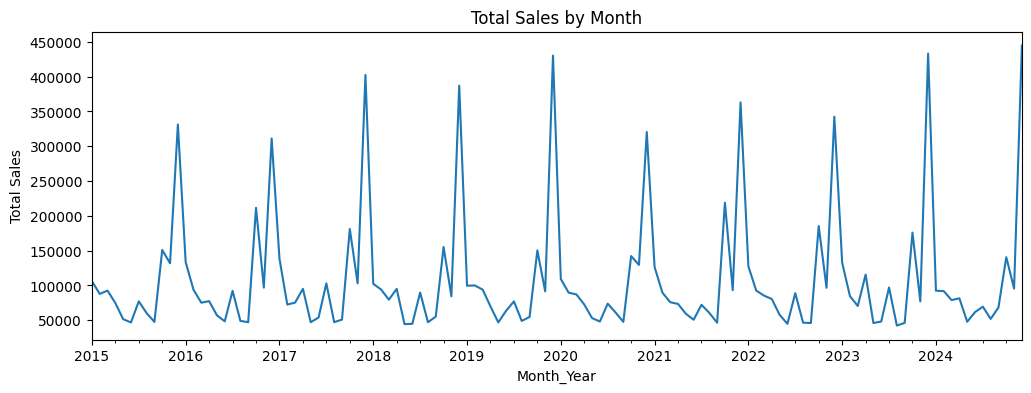

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 4))
plt.tight_layout()
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Total Sales by Month")
df_SalesByStore.plot()
plt.show()


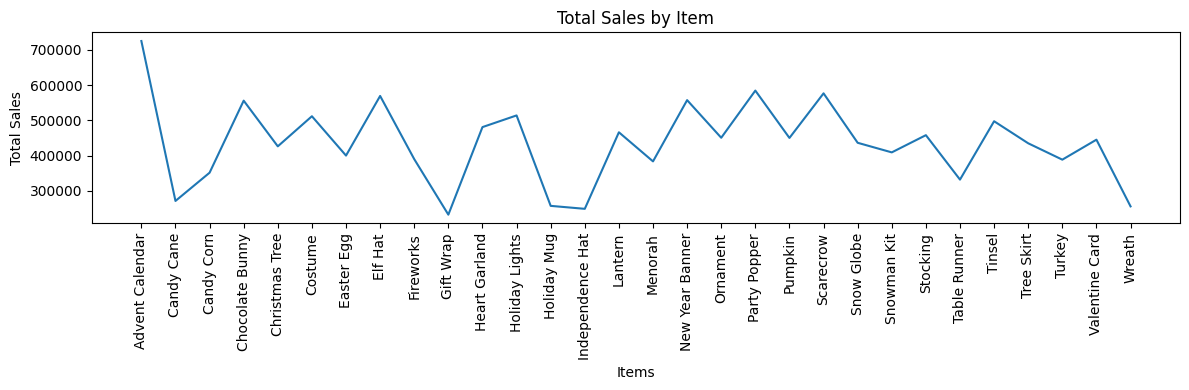

In [ ]:
df_SalesByItem.head()
items = sorted(df["Item"].unique())
y = df_SalesByItem.values
x = np.arange(len(items))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x, y)
ax.set_xticks(x, items, rotation="vertical")
ax.set_xlabel("Items")
ax.set_ylabel("Total Sales")
ax.set_title("Total Sales by Item")
plt.tight_layout()

plt.show()


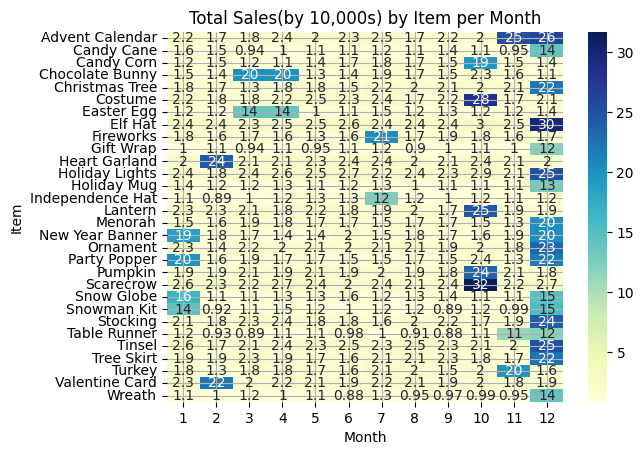

In [ ]:
#Total Sales by Item per Month, using a heat map
import seaborn as sns

df['Month'] = df['Date'].dt.month
heatmap_data = df.groupby(["Item", "Month"])["Total_Sales"].sum()/10000
heatmap_data = heatmap_data.unstack()
available_months = sorted(df["Month"].unique())

heatmap_data = heatmap_data[available_months]

# sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
sns.heatmap(heatmap_data, yticklabels=True, annot=True, cmap='YlGnBu')
# plt.figure(figsize=(8, 6))
yticklabels=True
plt.grid(True)
plt.xlabel("Month")
plt.ylabel("Item")
plt.title("Total Sales(by 10,000s) by Item per Month")
plt.show()

## 🤖 Machine Learning: Item-Level Sales Forecasting by Month

In this section, we trained separate Random Forest regression models for each holiday item to predict weekly **sales quantities** based solely on the **month** of the sale.

### Key Details:
- Models were trained individually for each item using historical sales up to **January 2021**.
- The **month** was used as the only feature to capture seasonality.
- We evaluated each model using:
  - **MAE (Mean Absolute Error)**: Average absolute prediction error
  - **MSE (Mean Squared Error)**: Penalizes larger errors
  - **RMSE (Root Mean Squared Error)**: Interpretable in same units as quantity sold

### Evaluation Insight:
Most models achieved:
- **MAE values between ~1.3 and 1.6**, indicating strong predictive performance
- **RMSE values between ~1.7 and 2.1**, which is consistent with slight volatility


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare feature (X) and target (y)
df_x = df.drop(columns=['Quantity'])  # Features — currently unused globally
df_y = df['Quantity']                 # Target

# Sort item names alphabetically
items = sorted(df["Item"].unique())

# Store models for each item
product_models = {}

for item in items:
    # Filter data for the current item
    product_data = df[df['Item'] == item]

    # Split into training and testing sets by cutoff date
    cutoff_date = '2021-01-01'
    train_data = product_data[product_data['Date'] <= cutoff_date]
    test_data = product_data[product_data['Date'] > cutoff_date]

    # Use month as the only feature (simple seasonal signal)
    X_train = train_data[['Month']]
    y_train = train_data['Quantity']
    X_test = test_data[['Month']]
    y_test = test_data['Quantity']

    # Train a Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Save the model for future use
    product_models[item] = model

    # Evaluate predictions
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print(f'{item} MAE: {mae:.2f}')
    print(f'{item} MSE: {mse:.2f}')
    print(f'{item} RMSE: {rmse:.2f}\n')


Advent Calendar MAE: 1.51
Advent Calendar MSE: 4.05
Advent Calendar RMSE: 2.01

Candy Cane MAE: 1.40
Candy Cane MSE: 3.62
Candy Cane RMSE: 1.90

Candy Corn MAE: 1.46
Candy Corn MSE: 4.07
Candy Corn RMSE: 2.02

Chocolate Bunny MAE: 1.60
Chocolate Bunny MSE: 4.41
Chocolate Bunny RMSE: 2.10

Christmas Tree MAE: 1.47
Christmas Tree MSE: 3.97
Christmas Tree RMSE: 1.99

Costume MAE: 1.33
Costume MSE: 3.07
Costume RMSE: 1.75

Easter Egg MAE: 1.59
Easter Egg MSE: 4.20
Easter Egg RMSE: 2.05

Elf Hat MAE: 1.44
Elf Hat MSE: 3.76
Elf Hat RMSE: 1.94

Fireworks MAE: 1.33
Fireworks MSE: 2.95
Fireworks RMSE: 1.72

Gift Wrap MAE: 1.38
Gift Wrap MSE: 3.41
Gift Wrap RMSE: 1.85

Heart Garland MAE: 1.31
Heart Garland MSE: 3.21
Heart Garland RMSE: 1.79

Holiday Lights MAE: 1.39
Holiday Lights MSE: 3.53
Holiday Lights RMSE: 1.88

Holiday Mug MAE: 1.40
Holiday Mug MSE: 3.71
Holiday Mug RMSE: 1.93

Independence Hat MAE: 1.37
Independence Hat MSE: 3.32
Independence Hat RMSE: 1.82

Lantern MAE: 1.45
Lantern MSE:

## 📦 Future Demand Forecasting by Month

In this section, we:
- Created a `future_data` DataFrame with unique months (1–12).
- Used our trained models to predict **expected monthly quantities** for each item.
- Applied a **7% buffer** (`* 1.07`) to predicted values to account for safety stock or anticipated growth.
- Stored the predictions in a combined `order_predictions_df`, which shows how much of each item we should order per month.

> 🔍 *Note*: Since we’re only using `Month` as a feature, no column alignment is strictly necessary. In future iterations, we can enrich predictions by adding more features such as `Store`, `Week`, or historical sales trends.


In [ ]:
# Prepare unique months for future prediction
future_data = pd.DataFrame({
    'Month': sorted(df['Month'].unique())  # Unique months from the dataset
})

# Create a DataFrame to store future quantity predictions per item
order_predictions_df = pd.DataFrame(columns=['Item', 'Month', 'Qty_To_Order'])

for item, model in product_models.items():
    # Predict future quantities for each month
    future_predictions = model.predict(future_data)

    # Slightly increase predictions (e.g., to account for growth/safety stock)
    predictions_df = pd.DataFrame({
        'Item': item,
        'Month': future_data['Month'],
        'Qty_To_Order': future_predictions * 1.07  # 7% buffer
    })

    # Append to main dataframe
    order_predictions_df = pd.concat([order_predictions_df, predictions_df], ignore_index=True)

# Display top of the result
order_predictions_df.head(12)


<ipython-input-12-7afceb884b23>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  order_predictions_df = pd.concat([order_predictions_df, predictions_df], ignore_index=True)


,Item,Month,Qty_To_Order
0,Advent Calendar,1,3.395472
1,Advent Calendar,2,3.358560
2,Advent Calendar,3,3.316450
3,Advent Calendar,4,3.312796
4,Advent Calendar,5,3.085988
5,Advent Calendar,6,3.296580
6,Advent Calendar,7,3.164910
7,Advent Calendar,8,3.081875
8,Advent Calendar,9,2.982938
9,Advent Calendar,10,3.045336


## ✅ Conclusion

In this notebook, we successfully simulated and analyzed seasonal sales data for holiday-themed items across Walmart stores using machine learning.

### Key Accomplishments:
- 📅 **Data Generation**: Created a 10-year dataset with 50,000 weekly records, incorporating seasonal demand patterns for 30+ holiday items.
- 📊 **Exploratory Data Analysis (EDA)**: Visualized item-level and month-level sales trends, confirming that peak demand aligns with holidays (e.g., pumpkins in October, candy canes in December).
- 🤖 **Modeling**: Trained individual Random Forest models for each item using only the `Month` feature. Despite using just a single input, the models achieved strong performance with low MAE and RMSE values.
- 📦 **Future Forecasting**: Predicted future monthly demand with a built-in buffer to inform proactive inventory planning.

### Insights:
- Seasonality alone is a powerful predictor for holiday items.
- Modeling each item separately allows for tailored inventory strategies.
- Even with minimal features, machine learning can yield actionable predictions when domain patterns are strong.

### Next Steps:
- Enhance models by incorporating additional features like `Store`, `Week`, or `historical lagged demand`.
- Validate predictions against real or held-out synthetic data to fine-tune buffer levels.
- Visualize future forecasts interactively (e.g., by item or store) to support merchandising decisions.

This notebook serves as a foundation for building more sophisticated demand forecasting pipelines and showcases the impact of even simple machine learning on retail operations.
